## Brain tumor classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
from keras.preprocessing.image import ImageDataGenerator

### Importing data & data augmentation

In [4]:
train_dir = r'C:\Users\Marcin\OneDrive\Pulpit\DATA_SCIENCE_NAUKA\Projekty\Brain_tumor_256X256\Data'

In [5]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=0.18,
                validation_split=0.1,
                horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size=(224,224),
                batch_size=16,
                subset='training',
                class_mode='sparse',
                seed=42)
validation_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size=(224,224),
                batch_size=16,
                subset='validation',
                class_mode='sparse',
                seed=42)

Found 2788 images belonging to 4 classes.
Found 308 images belonging to 4 classes.


### Data Visualization:

In [6]:
classes = train_generator.class_indices
reverse_classes = {val: key for key, val in classes.items()}

In [7]:
class_in_data = []
img_set = []
while len(class_in_data)<len(reverse_classes):
    images, labels = train_generator.next()
    for label, image in zip(labels,images):
        if label not in class_in_data:
            class_in_data.append(label)
            img_set.append(image)


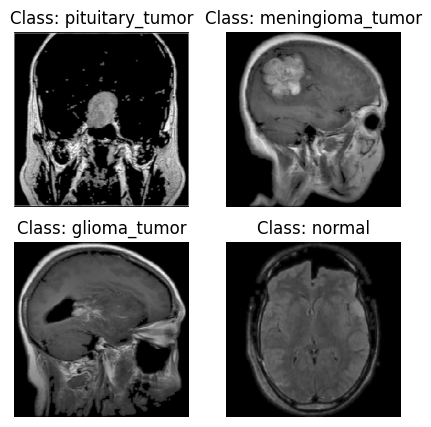

In [8]:
fig = plt.figure(figsize=(5,5))
for i, ax in enumerate(class_in_data):
    ax = fig.add_subplot(2,2,i+1)
    plt.imshow(img_set[i])
    ax.set_title(f'Class: {reverse_classes[class_in_data[i]]}')
    ax.axis('off')
plt.show()

### Model Building - Custom CNN:

In [9]:
from tensorflow.keras import layers,models

In [10]:
model = models.Sequential()

model.add(keras.layers.Conv2D(input_shape = (224,224,3),kernel_size=(3,3),
                                activation='relu',filters = 32,strides=1))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(kernel_size=(3,3),activation='relu',filters = 64,
                             strides=1))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(kernel_size=(3,3),activation='relu',filters = 128,
                             strides=1))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(keras.layers.Dense(128,activation='relu',
                             kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.Dense(64,activation='relu',
                            kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.Dense(4,activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

In [12]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = keras.optimizers.Adam(),
             metrics=['accuracy'])

In [13]:
checkpount_cb = keras.callbacks.ModelCheckpoint('brain_tumor.h5',
                                                save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

In [14]:
model_hsitory = model.fit(train_generator,epochs=50,
                          validation_data=validation_generator,
                          callbacks=[checkpount_cb,early_stop])

Epoch 1/50
175/175 [==============================] - 27s 140ms/step - loss: 1.9200 - accuracy: 0.4319 - val_loss: 1.4804 - val_accuracy: 0.5292
Epoch 2/50
175/175 [==============================] - 25s 143ms/step - loss: 1.3438 - accuracy: 0.5940 - val_loss: 1.3865 - val_accuracy: 0.6429
Epoch 3/50
175/175 [==============================] - 25s 143ms/step - loss: 1.1813 - accuracy: 0.6385 - val_loss: 1.1793 - val_accuracy: 0.6461
Epoch 4/50
175/175 [==============================] - 25s 142ms/step - loss: 1.0583 - accuracy: 0.7145 - val_loss: 1.0850 - val_accuracy: 0.6753
Epoch 5/50
175/175 [==============================] - 25s 144ms/step - loss: 0.9783 - accuracy: 0.7669 - val_loss: 1.1708 - val_accuracy: 0.6656
Epoch 6/50
175/175 [==============================] - 25s 145ms/step - loss: 0.9730 - accuracy: 0.7780 - val_loss: 0.9613 - val_accuracy: 0.7760
Epoch 7/50
175/175 [==============================] - 25s 141ms/step - loss: 0.8602 - accuracy: 0.8156 - val_loss: 0.9011 - val_ac

In [15]:
model.evaluate(validation_generator,batch_size=1)

20/20 [==============================] - 3s 126ms/step - loss: 0.7797 - accuracy: 0.8409


[0.779653012752533, 0.8409090638160706]

In [16]:
hist = pd.DataFrame(model_hsitory.history)

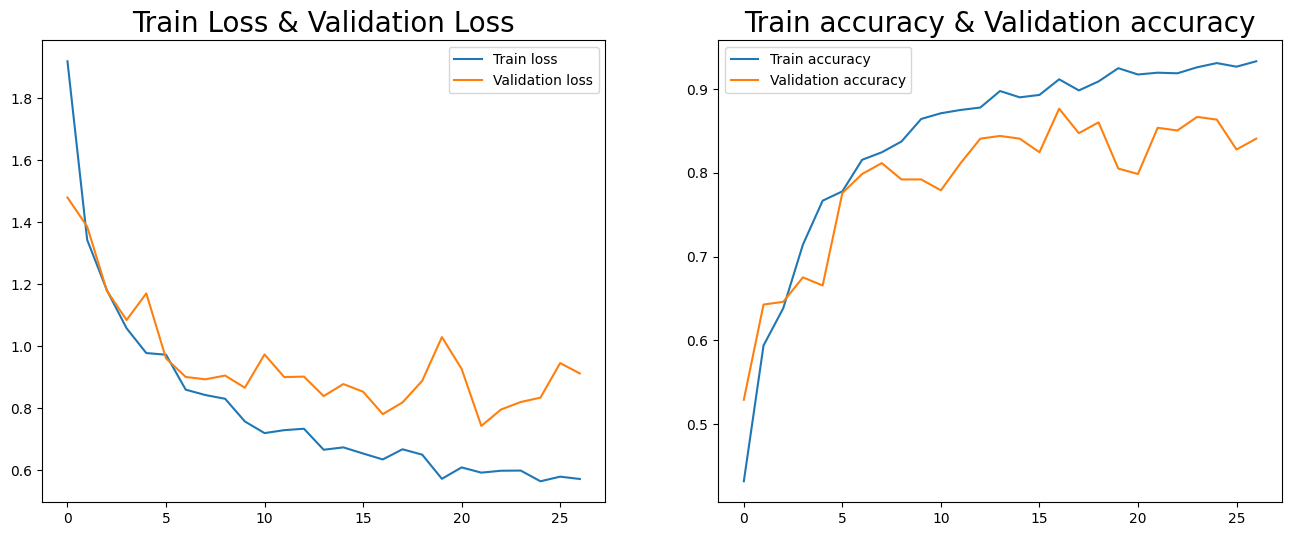

In [17]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(hist['loss'],label='Train loss')
plt.plot(hist['val_loss'],label='Validation loss')
plt.title('Train Loss & Validation Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist['accuracy'],label='Train accuracy')
plt.plot(hist['val_accuracy'],label='Validation accuracy')
plt.title('Train accuracy & Validation accuracy',fontsize=20)
plt.legend()

## Transfer learning with VGG16

In [18]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

In [19]:
model_vgg = models.Sequential()
model_vgg.add(conv_base)
conv_base.trainable = False
model_vgg.add(keras.layers.Flatten())
model_vgg.add(layers.Dropout(0.4))
model_vgg.add(keras.layers.Dense(4,activation=keras.activations.softmax))

In [20]:
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 100356    
Total params: 14,815,044
Trainable params: 100,356
Non-trainable params: 14,714,688
_________________________________________________________________


In [21]:
model_vgg.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = keras.optimizers.Adam(learning_rate=0.0005),
             metrics=['accuracy'])

In [22]:
checkpount_cb_vgg = keras.callbacks.ModelCheckpoint('brain_tumor_vgg.h5',
                                                save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

In [23]:
model_history_vgg = model_vgg.fit(train_generator,epochs=50,
                          validation_data=validation_generator,
                          callbacks=[checkpount_cb_vgg,early_stop])

Epoch 1/50
175/175 [==============================] - 31s 153ms/step - loss: 0.8483 - accuracy: 0.6524 - val_loss: 0.5359 - val_accuracy: 0.8052
Epoch 2/50
175/175 [==============================] - 25s 145ms/step - loss: 0.4764 - accuracy: 0.8264 - val_loss: 0.3996 - val_accuracy: 0.8766
Epoch 3/50
175/175 [==============================] - 25s 140ms/step - loss: 0.3907 - accuracy: 0.8468 - val_loss: 0.3712 - val_accuracy: 0.8636
Epoch 4/50
175/175 [==============================] - 25s 140ms/step - loss: 0.3248 - accuracy: 0.8777 - val_loss: 0.3317 - val_accuracy: 0.8831
Epoch 5/50
175/175 [==============================] - 25s 141ms/step - loss: 0.2611 - accuracy: 0.9071 - val_loss: 0.4134 - val_accuracy: 0.8377
Epoch 6/50
175/175 [==============================] - 25s 145ms/step - loss: 0.2496 - accuracy: 0.9093 - val_loss: 0.3488 - val_accuracy: 0.8766
Epoch 7/50
175/175 [==============================] - 25s 145ms/step - loss: 0.2229 - accuracy: 0.9186 - val_loss: 0.3160 - val_ac

In [24]:
model_vgg.evaluate(validation_generator,batch_size=1)

20/20 [==============================] - 3s 124ms/step - loss: 0.2639 - accuracy: 0.9091


[0.2638528645038605, 0.9090909361839294]

In [25]:
hist_vgg = pd.DataFrame(model_history_vgg.history)

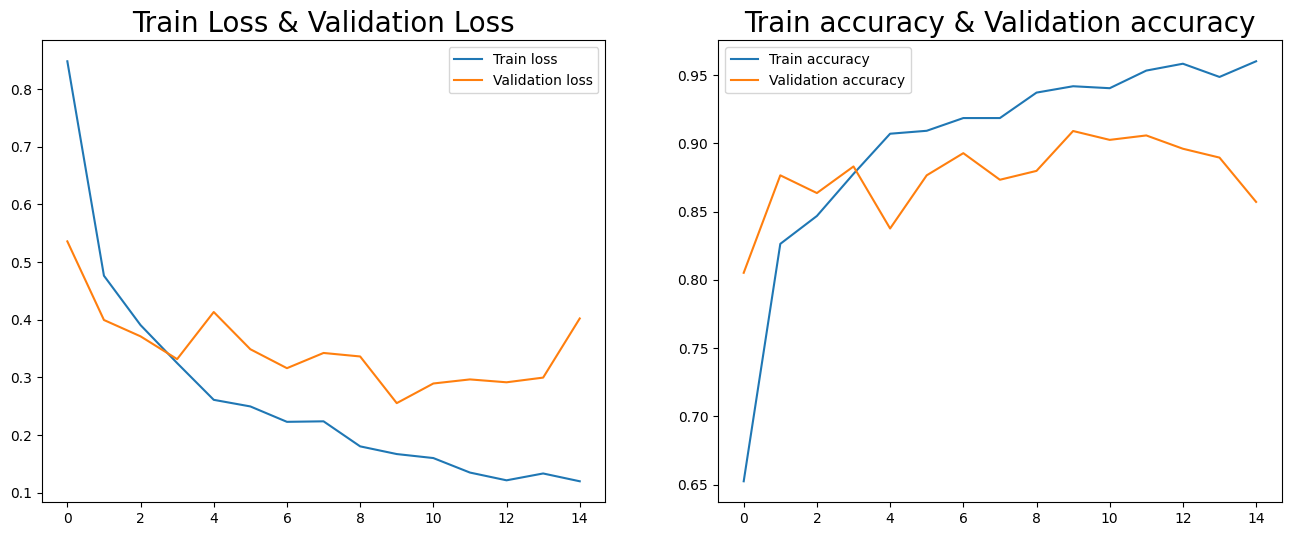

In [26]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(hist_vgg['loss'],label='Train loss')
plt.plot(hist_vgg['val_loss'],label='Validation loss')
plt.title('Train Loss & Validation Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_vgg['accuracy'],label='Train accuracy')
plt.plot(hist_vgg['val_accuracy'],label='Validation accuracy')
plt.title('Train accuracy & Validation accuracy',fontsize=20)
plt.legend()

## Fine tuning VGG16 model

In [27]:
from keras.models import load_model
model_finetune = load_model('brain_tumor_vgg.h5')

In [28]:
model_finetune.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 100356    
Total params: 14,815,044
Trainable params: 100,356
Non-trainable params: 14,714,688
_________________________________________________________________


In [29]:
for layer in model_finetune.layers[0].layers[:7]:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000019E0B0BF970> True
<keras.layers.convolutional.Conv2D object at 0x0000019E0B0BFA00> False
<keras.layers.convolutional.Conv2D object at 0x0000019E0B0BFFD0> False
<keras.layers.pooling.MaxPooling2D object at 0x0000019E0B0D5790> False
<keras.layers.convolutional.Conv2D object at 0x0000019E0B0D5850> False
<keras.layers.convolutional.Conv2D object at 0x0000019E0B0D5F10> False
<keras.layers.pooling.MaxPooling2D object at 0x0000019E0B0D5CA0> False


In [30]:
for layer in model_finetune.layers[0].layers[:7]:
    layer.trainable = True

In [31]:
for layer in model_finetune.layers[0].layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000019E0B0BF970> True
<keras.layers.convolutional.Conv2D object at 0x0000019E0B0BFA00> True
<keras.layers.convolutional.Conv2D object at 0x0000019E0B0BFFD0> True
<keras.layers.pooling.MaxPooling2D object at 0x0000019E0B0D5790> True
<keras.layers.convolutional.Conv2D object at 0x0000019E0B0D5850> True
<keras.layers.convolutional.Conv2D object at 0x0000019E0B0D5F10> True
<keras.layers.pooling.MaxPooling2D object at 0x0000019E0B0D5CA0> True
<keras.layers.convolutional.Conv2D object at 0x0000019E0B0D8520> False
<keras.layers.convolutional.Conv2D object at 0x0000019E0B0D8BE0> False
<keras.layers.convolutional.Conv2D object at 0x0000019E0B0D8E80> False
<keras.layers.pooling.MaxPooling2D object at 0x0000019E0B0DE640> False
<keras.layers.convolutional.Conv2D object at 0x0000019E0B0DE700> False
<keras.layers.convolutional.Conv2D object at 0x0000019E0B0DEDC0> False
<keras.layers.convolutional.Conv2D object at 0x0000019E0B0DEF10> False
<keras.laye

In [32]:
model_finetune.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = keras.optimizers.RMSprop(learning_rate=0.00005),
             metrics=['accuracy'])

In [33]:
checkpount_cb_vgg = keras.callbacks.ModelCheckpoint('brain_tumor_vgg_finetune.h5',
                                                save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

In [34]:
fine_tune_vgg = model_finetune.fit(train_generator,epochs=50,
                          validation_data=validation_generator,
                          callbacks=[checkpount_cb_vgg,early_stop],
                                  initial_epoch=model_history_vgg.epoch[-1])

Epoch 15/50
175/175 [==============================] - 60s 294ms/step - loss: 0.1467 - accuracy: 0.9451 - val_loss: 0.3400 - val_accuracy: 0.8766
Epoch 16/50
175/175 [==============================] - 51s 291ms/step - loss: 0.1360 - accuracy: 0.9494 - val_loss: 0.3401 - val_accuracy: 0.8799
Epoch 17/50
175/175 [==============================] - 53s 303ms/step - loss: 0.1232 - accuracy: 0.9577 - val_loss: 0.3155 - val_accuracy: 0.8864
Epoch 18/50
175/175 [==============================] - 53s 301ms/step - loss: 0.1286 - accuracy: 0.9555 - val_loss: 0.2681 - val_accuracy: 0.9091
Epoch 19/50
175/175 [==============================] - 50s 286ms/step - loss: 0.1133 - accuracy: 0.9616 - val_loss: 0.2546 - val_accuracy: 0.9221
Epoch 20/50
175/175 [==============================] - 49s 281ms/step - loss: 0.1089 - accuracy: 0.9638 - val_loss: 0.2391 - val_accuracy: 0.9058
Epoch 21/50
175/175 [==============================] - 50s 286ms/step - loss: 0.1040 - accuracy: 0.9598 - val_loss: 0.2658 -

In [35]:
model_finetune.evaluate(validation_generator,batch_size=1)

20/20 [==============================] - 3s 130ms/step - loss: 0.2186 - accuracy: 0.9286


[0.21864543855190277, 0.9285714030265808]

In [36]:
hist_vgg_finetune = pd.DataFrame(fine_tune_vgg.history)

In [39]:
hist_vgg_1 = pd.concat([hist_vgg,hist_vgg_finetune],ignore_index=True)

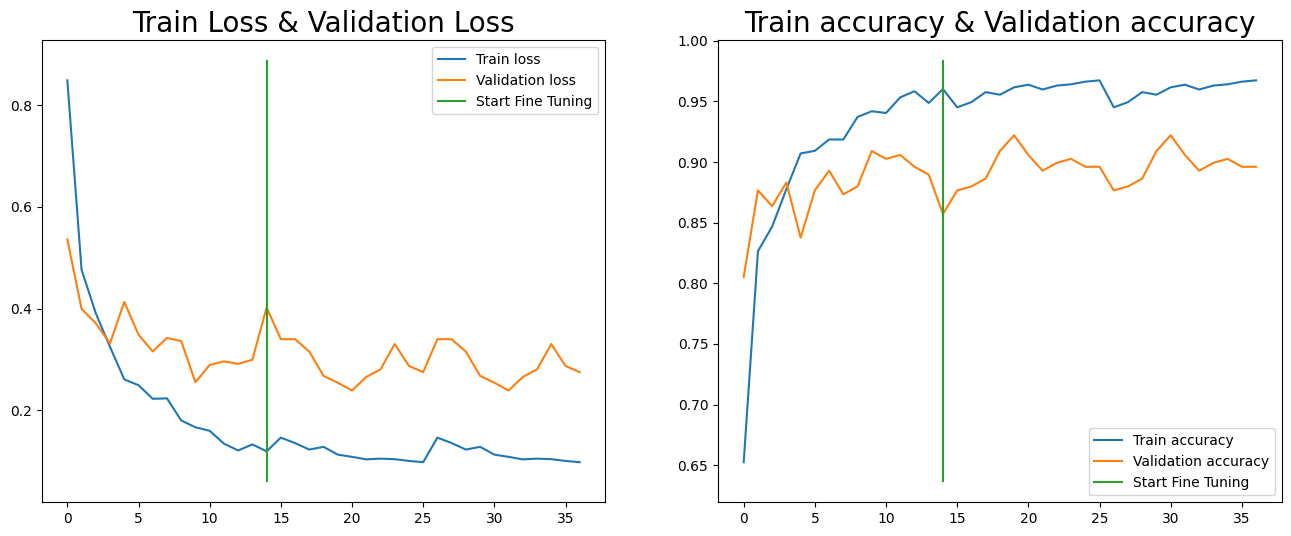

In [40]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(hist_vgg_1['loss'],label='Train loss')
plt.plot(hist_vgg_1['val_loss'],label='Validation loss')
plt.plot([model_history_vgg.epoch[-1],model_history_vgg.epoch[-1]],
          plt.ylim(), label='Start Fine Tuning')
plt.title('Train Loss & Validation Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_vgg_1['accuracy'],label='Train accuracy')
plt.plot(hist_vgg_1['val_accuracy'],label='Validation accuracy')
plt.plot([model_history_vgg.epoch[-1],model_history_vgg.epoch[-1]],
          plt.ylim(), label='Start Fine Tuning')
plt.title('Train accuracy & Validation accuracy',fontsize=20)
plt.legend()